### Understanding Regularization

To understand how different families of regularization affect CNN generalization on EuroSAT (RGB), I trained the same convolutional architecture under six configurations. I started with a deliberately overfitting baseline, then progressively introduced weight decay (L2), dropout and spatial dropout, data augmentation, batch normalization and early stopping, and finally a ‘best-practice’ combination model

GitHub Repo: https://github.com/vgowtham009/eurosat-regularization-tutorial.git

###**EuroSAT Dataset - RGB**

In [1]:
# Setup and Imports

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.AUTOTUNE


In [2]:
# Loading EuroSAT RGB dataset

# We use the RGB version: 64x64x3 images, 10 land use classes.
# We'll create three splits from the single 'train' split:
#   - train: first 30% of the dataset (limited data to encourage overfitting)
#   - val:   next 10%
#   - test:  remaining 60% (held-out)

train_split = "train[:30%]"
val_split   = "train[30%:40%]"
test_split  = "train[40%:]"

(ds_train, ds_val, ds_test), ds_info = tfds.load(
    "eurosat/rgb",
    split=[train_split, val_split, test_split],
    as_supervised=True,  # gives (image, label)
    with_info=True,
)

num_classes = ds_info.features["label"].num_classes
input_shape = ds_info.features["image"].shape
print("Input shape:", input_shape, "| Num classes:", num_classes)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.EAW9IL_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
Input shape: (64, 64, 3) | Num classes: 10


# 2. Data Preprocessing & Data Pipeline

In [3]:
# Preprocessing & Data Pipelines(tf.data)

def preprocess(image, label):
    # Convert to float and normalize to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

BATCH_SIZE = 64

train_ds = (
    ds_train
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    ds_val
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    ds_test
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


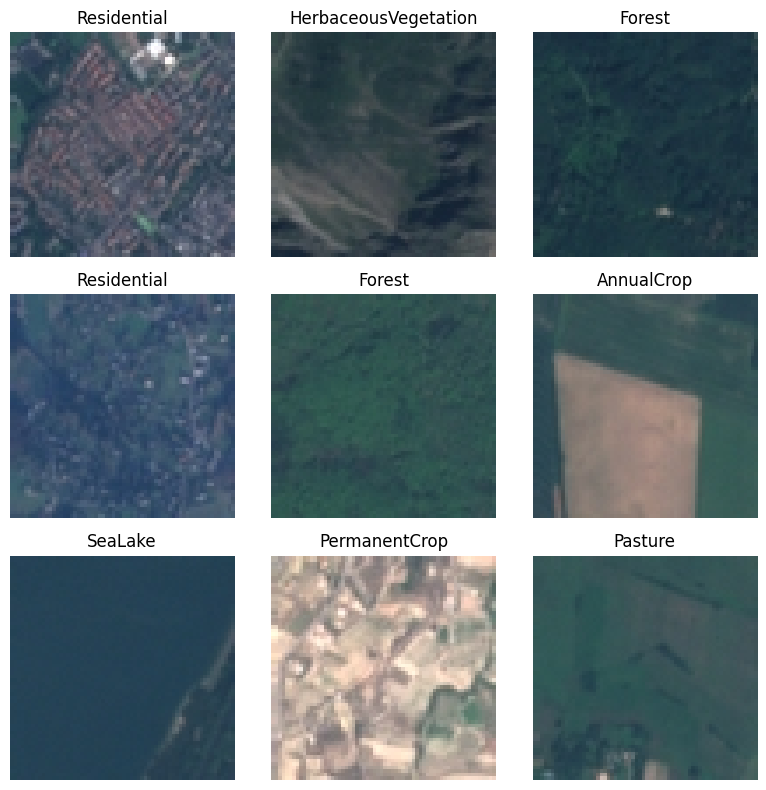

In [4]:
# Visualize a few training samples

class_names = ds_info.features["label"].names

def show_batch(dataset, n=9):
    images, labels = next(iter(dataset))
    images = images[:n]
    labels = labels[:n]

    plt.figure(figsize=(8, 8))
    for i in range(n):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_batch(train_ds)


# 3. Data Augmentation

In [5]:
# Data Augmentation layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.1),
    ],
    name="data_augmentation",
)


# 4. CNN Model - Building Block

In [6]:
# CNN model builder with config. reg.

def build_cnn_model(
    input_shape=(64, 64, 3),
    num_classes=10,
    use_batchnorm=False,
    l2_factor=0.0,
    dropout_rate=0.0,
    spatial_dropout_rate=0.0,
    use_data_augmentation=False,
):
    """
    Build a CNN for EuroSAT with optional:
      - Batch Normalization
      - L2 (weight decay)
      - Dropout in dense layer
      - SpatialDropout2D in conv blocks
      - Data augmentation at the input
    """
    weight_reg = regularizers.l2(l2_factor) if l2_factor > 0 else None

    inputs = keras.Input(shape=input_shape)

    x = inputs
    if use_data_augmentation:
        x = data_augmentation(x)

    # Block 1
    x = layers.Conv2D(
        32, (3, 3), padding="same",
        kernel_regularizer=weight_reg,
        use_bias=not use_batchnorm,
    )(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    if spatial_dropout_rate > 0:
        x = layers.SpatialDropout2D(spatial_dropout_rate)(x)

    x = layers.Conv2D(
        32, (3, 3), padding="same",
        kernel_regularizer=weight_reg,
        use_bias=not use_batchnorm,
    )(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2
    x = layers.Conv2D(
        64, (3, 3), padding="same",
        kernel_regularizer=weight_reg,
        use_bias=not use_batchnorm,
    )(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    if spatial_dropout_rate > 0:
        x = layers.SpatialDropout2D(spatial_dropout_rate)(x)

    x = layers.Conv2D(
        64, (3, 3), padding="same",
        kernel_regularizer=weight_reg,
        use_bias=not use_batchnorm,
    )(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 3
    x = layers.Conv2D(
        128, (3, 3), padding="same",
        kernel_regularizer=weight_reg,
        use_bias=not use_batchnorm,
    )(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)


    x = layers.Flatten()(x)
    x = layers.Dense(
        256,
        kernel_regularizer=weight_reg,
        use_bias=True,
    )(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="eurosat_cnn")
    return model


# 5. Training Function, Saving Histories

In [7]:
# Training helper across all config.

def train_config(
    name,
    use_batchnorm=False,
    l2_factor=0.0,
    dropout_rate=0.0,
    spatial_dropout_rate=0.0,
    use_data_augmentation=False,
    use_early_stopping=False,
    max_epochs=30,
):
    print(f"\n===== Training config: {name} =====")

    model = build_cnn_model(
        input_shape=input_shape,
        num_classes=num_classes,
        use_batchnorm=use_batchnorm,
        l2_factor=l2_factor,
        dropout_rate=dropout_rate,
        spatial_dropout_rate=spatial_dropout_rate,
        use_data_augmentation=use_data_augmentation,
    )

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    callbacks = []
    if use_early_stopping:
        early_stop = keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
        )
        callbacks.append(early_stop)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=max_epochs,
        callbacks=callbacks,
        verbose=2,
    )

    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    print(f"{name} | Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

    return model, history, {"test_acc": test_acc, "test_loss": test_loss}


# 6. Whole Experiment Set(6)

In [8]:
# Run experiments

histories = {}
results = {}

MAX_EPOCHS = 25

# 1. Baseline: no regularizations
model_base, hist_base, res_base = train_config(
    name="baseline",
    use_batchnorm=False,
    l2_factor=0.0,
    dropout_rate=0.0,
    spatial_dropout_rate=0.0,
    use_data_augmentation=False,
    use_early_stopping=False,
    max_epochs=MAX_EPOCHS,
)
histories["baseline"] = hist_base
results["baseline"] = res_base

# 2. L2 only (weight decay)
model_l2, hist_l2, res_l2 = train_config(
    name="l2_only",
    use_batchnorm=False,
    l2_factor=1e-4,
    dropout_rate=0.0,
    spatial_dropout_rate=0.0,
    use_data_augmentation=False,
    use_early_stopping=False,
    max_epochs=MAX_EPOCHS,
)
histories["l2_only"] = hist_l2
results["l2_only"] = res_l2

# 3. Dropout + SpatialDropout2D
model_drop, hist_drop, res_drop = train_config(
    name="dropout_spatial",
    use_batchnorm=False,
    l2_factor=0.0,
    dropout_rate=0.5,
    spatial_dropout_rate=0.2,
    use_data_augmentation=False,
    use_early_stopping=False,
    max_epochs=MAX_EPOCHS,
)
histories["dropout_spatial"] = hist_drop
results["dropout_spatial"] = res_drop

# 4. Data augmentation only
model_aug, hist_aug, res_aug = train_config(
    name="augmentation_only",
    use_batchnorm=False,
    l2_factor=0.0,
    dropout_rate=0.0,
    spatial_dropout_rate=0.0,
    use_data_augmentation=True,
    use_early_stopping=False,
    max_epochs=MAX_EPOCHS,
)
histories["augmentation_only"] = hist_aug
results["augmentation_only"] = res_aug

# 5. BatchNorm + EarlyStopping
model_bn_es, hist_bn_es, res_bn_es = train_config(
    name="batchnorm_earlystop",
    use_batchnorm=True,
    l2_factor=0.0,
    dropout_rate=0.0,
    spatial_dropout_rate=0.0,
    use_data_augmentation=False,
    use_early_stopping=True,
    max_epochs=MAX_EPOCHS,
)
histories["batchnorm_earlystop"] = hist_bn_es
results["batchnorm_earlystop"] = res_bn_es

# 6. Strong combo: L2 + BatchNorm + Dropout + SpatialDropout2D + Augmentation + EarlyStopping
model_combo, hist_combo, res_combo = train_config(
    name="strong_combo",
    use_batchnorm=True,
    l2_factor=1e-4,
    dropout_rate=0.5,
    spatial_dropout_rate=0.2,
    use_data_augmentation=True,
    use_early_stopping=True,
    max_epochs=MAX_EPOCHS,
)
histories["strong_combo"] = hist_combo
results["strong_combo"] = res_combo



===== Training config: baseline =====
Epoch 1/25
127/127 - 20s - 158ms/step - accuracy: 0.3838 - loss: 1.5915 - val_accuracy: 0.5333 - val_loss: 1.1992
Epoch 2/25
127/127 - 3s - 22ms/step - accuracy: 0.5994 - loss: 1.0489 - val_accuracy: 0.6441 - val_loss: 0.9820
Epoch 3/25
127/127 - 3s - 22ms/step - accuracy: 0.6819 - loss: 0.8649 - val_accuracy: 0.6200 - val_loss: 1.0256
Epoch 4/25
127/127 - 3s - 20ms/step - accuracy: 0.7252 - loss: 0.7544 - val_accuracy: 0.7122 - val_loss: 0.7991
Epoch 5/25
127/127 - 3s - 21ms/step - accuracy: 0.8058 - loss: 0.5414 - val_accuracy: 0.7604 - val_loss: 0.6838
Epoch 6/25
127/127 - 3s - 21ms/step - accuracy: 0.8323 - loss: 0.4757 - val_accuracy: 0.7496 - val_loss: 0.7358
Epoch 7/25
127/127 - 3s - 22ms/step - accuracy: 0.8589 - loss: 0.3946 - val_accuracy: 0.7907 - val_loss: 0.6251
Epoch 8/25
127/127 - 3s - 21ms/step - accuracy: 0.8930 - loss: 0.3114 - val_accuracy: 0.8122 - val_loss: 0.5877
Epoch 9/25
127/127 - 3s - 20ms/step - accuracy: 0.9237 - loss: 

# 7. Plotting Functions

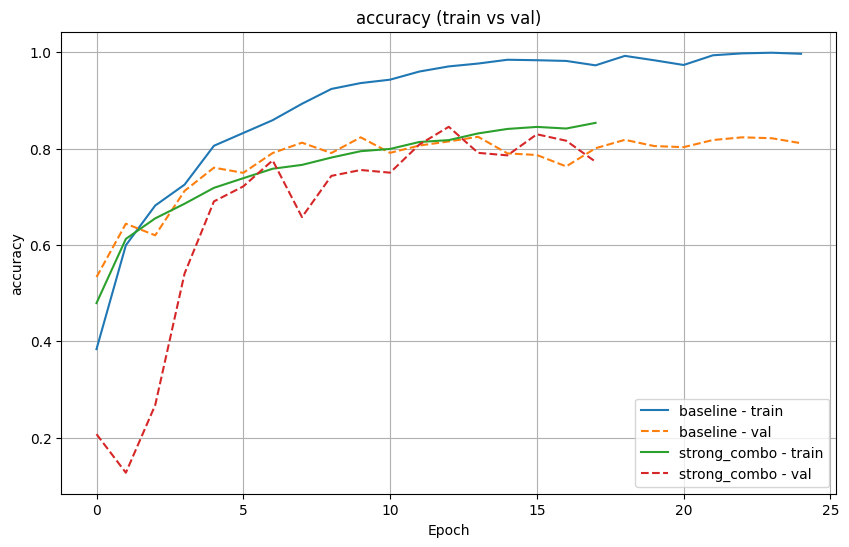

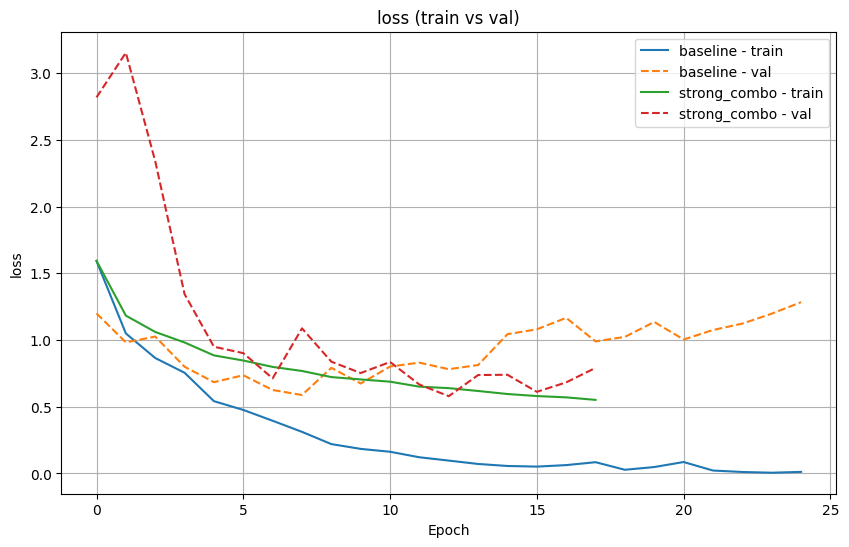

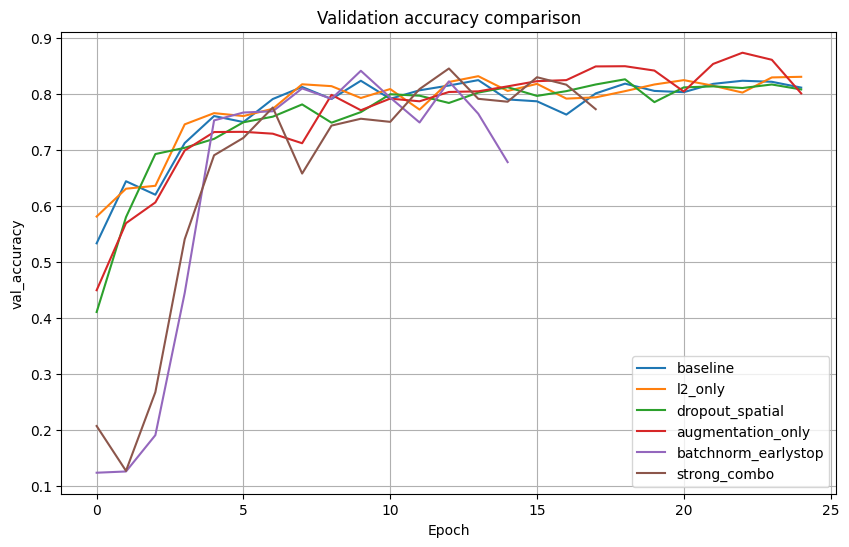

In [11]:
# Training and Validation Plots

def plot_history(metric="accuracy", configs=None):
    if configs is None:
        configs = list(histories.keys())

    plt.figure(figsize=(10, 6))
    for name in configs:
        hist = histories[name]
        plt.plot(hist.history[metric], label=f"{name} - train")
        val_metric = "val_" + metric
        if val_metric in hist.history:
            plt.plot(hist.history[val_metric], linestyle="--", label=f"{name} - val")
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.title(f"{metric} (train vs val)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Baseline Vs Strong Combo
plot_history(metric="accuracy", configs=["baseline", "strong_combo"])
plot_history(metric="loss", configs=["baseline", "strong_combo"])

# Compare validation accuracy across all configs
plt.figure(figsize=(10, 6))
for name, hist in histories.items():
    if "val_accuracy" in hist.history:
        plt.plot(hist.history["val_accuracy"], label=name)
plt.xlabel("Epoch")
plt.ylabel("val_accuracy")
plt.title("Validation accuracy comparison")
plt.legend()
plt.grid(True)
plt.show()


# Observations:




###Train Vs Loss - Accuracy:

Regularization reduces the model’s ability to overfit, which is why the strong-combo model maintains a small gap between training and validation accuracy despite having similar capacity to the baseline.

### Train Vs Loss - Loss:

The baseline model continues to optimize the training loss even after validation loss begins to increase, indicating memorization. Regularization in the strong-combo model smooths the loss landscape, reduces variance, and prevents this late-epoch divergence


###Validation Accuracy - All config.

The fact that most models converge to a similar validation accuracy suggests that EuroSAT provides strong discriminative features. However, augmentation-based regularization methods consistently outperform weight-only (L2) and activation-only (dropout) regularizers, highlighting the importance of data-space regularization for satellite imagery.

# 8. Final Results - Summary

In [12]:
# Summary Table for Test results

print(".   Test performance summary.  ")
for name, res in results.items():
    print(f"{name:20s} | acc = {res['test_acc']:.4f} | loss = {res['test_loss']:.4f}")


.   Test performance summary.  
baseline             | acc = 0.8074 | loss = 1.3322
l2_only              | acc = 0.8199 | loss = 0.9046
dropout_spatial      | acc = 0.8133 | loss = 0.7891
augmentation_only    | acc = 0.8157 | loss = 0.5416
batchnorm_earlystop  | acc = 0.8399 | loss = 0.5677
strong_combo         | acc = 0.8529 | loss = 0.5451


###Observation:

Interestingly, the combined regularization model did not outperform the best individual regularizers. This suggests that regularization must be balanced; stacking too many constraints can reduce model capacity to the point of underfitting. The best-performing models were those that augmented the training distribution (augmentation-only) or stabilized training (batchnorm + early stopping), indicating that EuroSAT benefits most from data-space and training-time regularization rather than heavy weight or activation constraints.